# Imports

In [4]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
import time
import signal
from typing import List, Tuple

# Degree Network

Create a network with a desired degree - code start taken from lecture and ChatGPT was used to help create a working version. Link to chat: https://chat.openai.com/share/6d50a46c-cb21-4e5d-9173-7e5b37c031d3


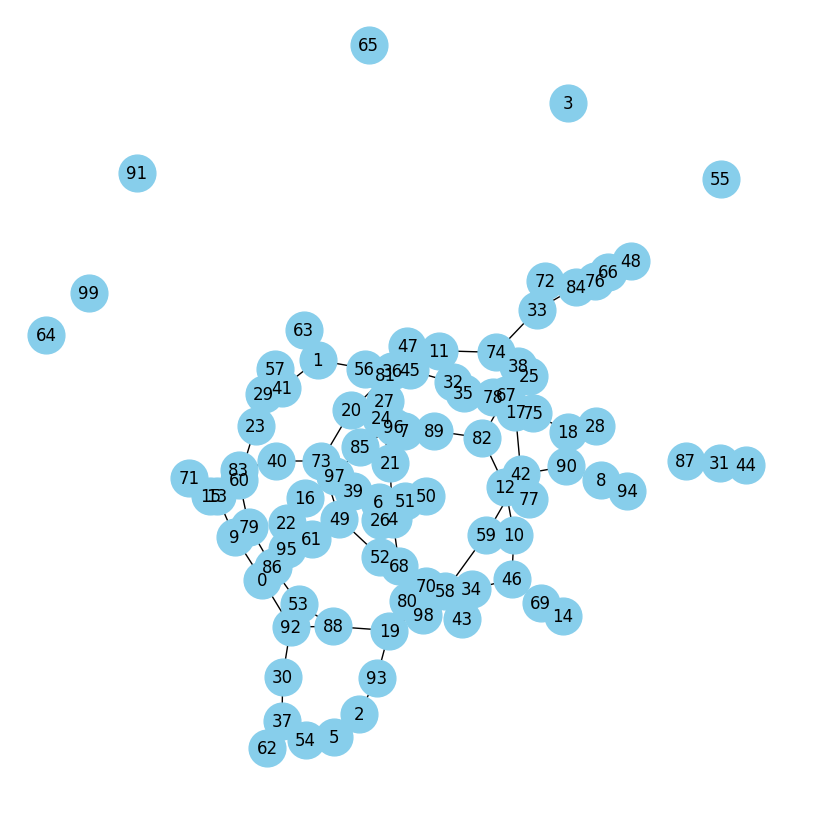

In [5]:


def configuration_A(S):
    """Configuration model with degree sequence S"""
    stubs = []
    for i in range(len(S)):
        for j in range(S[i]):
            stubs.append(i)
    n = nx.Graph()
    n.add_nodes_from(range(len(S)))  # Ensure the graph has len(S) nodes
    while len(stubs) > 1:  # Need at least 2 stubs to form an edge
        v, w = random.sample(stubs, 2)
        if v != w:  # Avoid self-loops
            n.add_edge(v, w)
            # Remove v, w from stubs
            stubs.remove(v)
            stubs.remove(w)
    return n

def configuration_B(n, P):
    """Configuration model with degree distribution P"""
    S = [1]
    while not nx.is_valid_degree_sequence_erdos_gallai(S):
        S = random.choices(population=range(len(P)), weights=P, k=n)
    return configuration_A(S)
def plot_graph(G):
    """Plot the given graph G using matplotlib"""
    plt.figure(figsize=(8, 8))
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='k')
    plt.show()


def plot_degree_distribution(G, P):
    """Plot the degree distribution of graph G and compare it with distribution P"""
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    # Also plot the theoretical distribution P for comparison
    theoretical_degrees = range(len(P))
    plt.plot(theoretical_degrees, [p*n for p in P], 'r-', label='Theoretical distribution')
    plt.legend()
    plt.show()



n = 100  # Number of nodes
P = [0.1, 0.2, 0.3, 0.4]  # Example distribution for demonstration


graph = configuration_B(n, P)
plot_graph(graph)

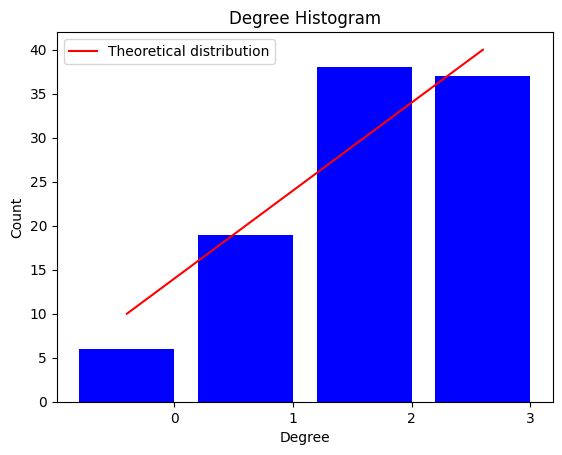

In [6]:
plot_degree_distribution(graph, P)

# model

Fits clustering and check with r and d

In [7]:
# assistance from ChatGPT4
# https://chat.openai.com/share/decf87c3-0c7f-4cee-84aa-42475c26e25e

import networkx as nx
import random
import time
import signal

# Timeout handler
class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException

def model1(G: nx.Graph, c_current: float, cluster: float, allowed_error: float, 
           nodes_per_round: int, seed: int = 42) -> Tuple[nx.Graph, int, List[float]]:
    """
    Modifies a graph to achieve a target clustering coefficient within a specified error margin,
    subject to a maximum runtime.

    :param G: A networkx graph on which operations will be performed.
    :param c_current: Current clustering coefficient of the graph.
    :param cluster: Target clustering coefficient.
    :param allowed_error: Acceptable margin of error for clustering coefficient.
    :param nodes_per_round: Number of nodes to consider for new connections each round.
    :param seed: Seed for the random number generator to ensure reproducibility.
    :return: A tuple containing the modified graph, the number of iterations completed, and
             the history of clustering coefficients as a list.
    """
    random.seed(seed)  # Seed the random number generator for reproducibility
    c_steps = [c_current]  # Tracks changes of clustering coefficient
    i = 0  # Iteration counter
    cluster_bound = [cluster - allowed_error, cluster + allowed_error]  # Clustering bounds
    start_time = time.time() # Record the start time

    # Setup timeout handler to avoid infinite execution
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(3600)  # Set the alarm for 60 minutes

    try:
        while c_current < cluster_bound[0] or c_current > cluster_bound[1]:
            i += 1

            for node in G.nodes():
                current_links = list(G[node]) # Access current links as a list

                if current_links:
                    link_to_remove = random.choice(current_links) # Randomly select one link to remove
                    G.remove_edge(node, link_to_remove) # Remove the selected link

                # Potential new links, excluding current neighbors and the node itself
                possible_new_links = [n for n in G.nodes() if n not in current_links and n != node]

                # Samples nodes for potential connection if there are more than enough candidates
                if len(possible_new_links) > nodes_per_round:
                    selected_nodes = random.sample(possible_new_links, nodes_per_round)
                else:
                    selected_nodes = possible_new_links # Use all possible links

                c_possible = []

                for possible in selected_nodes:
                    G.add_edge(node, possible)  # Temporarily add the new link
                    c_possible.append(nx.average_clustering(G))  # Calculate new clustering coefficient
                    G.remove_edge(node, possible)  # Remove the temporary link

                # Select the best new link if there are possible new links
                if c_possible:
                    best_node = selected_nodes[c_possible.index(max(c_possible))]
                    G.add_edge(node, best_node)

            c_current = nx.average_clustering(G)  # Update the clustering coefficient
            c_steps.append(c_current)  # Track the clustering coefficient progression

        signal.alarm(0)  # Disable the alarm
        execution_time = time.time() - start_time # Calculate total execution time
        print(f"Total execution time: {execution_time:.2f} seconds")
        return G, i, c_steps # Return the graph, iteration count, and clustering steps

    except TimeoutException:
        print("Function execution failed due to timeout.")
        execution_time = time.time() - start_time # Calculate execution time until timeout
        print(f"Total execution time: {execution_time:.2f} seconds")
        return G, i, c_steps  # Return the graph, iteration count, and clustering steps so far

In [8]:
# check how good the model is


def analyze_graph(G):
    # Check if the graph is connected; this is required to compute the diameter
    if nx.is_connected(G):
        diameter = nx.diameter(G)
        print(f"Diameter of the graph: {diameter}")
    else:
        print("Graph is not connected; diameter of the giant component will be calculated.")
        # Find the largest connected component (giant component)
        giant_component = max(nx.connected_components(G), key=len)
        G_giant = G.subgraph(giant_component).copy()

        # Diameter of the giant component
        diameter = nx.diameter(G_giant)
        print(f"Diameter of the giant component: {diameter}")


    # Average Clustering Coefficient
    avg_clustering = nx.average_clustering(G)
    print(f"Average Clustering Coefficient: {avg_clustering}")

    # Degree Distribution
    degrees = [G.degree(n) for n in G.nodes()]
    degree_counts = np.bincount(degrees)
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(degree_counts)), degree_counts, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()


In [9]:
import pandas as pd
# Meet's stuff
Sydney = pd.read_csv("Sydney.csv")
SiouxFalls = pd.read_csv("SiouxFalls.csv")
Anaheim = pd.read_csv("Anaheim.csv")
BerlinFriedrichshain = pd.read_csv("Berlin-Friedrichshain.csv")
BerlinMitteCenter = pd.read_csv("Berlin-Mitte-Center.csv")
Barcelona = pd.read_csv("Barcelona.csv")
EasternMassachusetts = pd.read_csv("Eastern-Massachusetts.csv")
Winnipeg = pd.read_csv("Winnipeg.csv")

In [10]:
ana_net = bar_net = bf_net = bmc_net = em_net = sioux_net = syd_net = win_net = nx.Graph()

places = [Anaheim, Barcelona, BerlinFriedrichshain, BerlinMitteCenter, EasternMassachusetts, SiouxFalls, Sydney, Winnipeg]
graphs = [ana_net, bar_net, bf_net, bmc_net, em_net, sioux_net, syd_net, win_net]

for i in range(len(places)):
  for idx, row in places[i].iterrows():
    graphs[i].add_edge(row['init_node'], row['term_node'], **row.drop(['init_node', 'term_node']).to_dict())

In [11]:
# get a degree distribution from Eastern Massachusetts
em_degrees = [em_net.degree(n) for n in em_net.nodes()]
em_degree_counts = np.bincount(em_degrees)

In [12]:
# make that random model with that
em_graph = configuration_B(74, em_degree_counts)

In [13]:
em_graph_avg = nx.average_clustering(em_graph)

In [14]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.2869
em_model, em_i, em_c_steps = model1(em_graph, em_graph_avg, c, c * 0.1, 5)

Total execution time: 15.80 seconds


In [15]:
em_model

In [16]:
em_i

123

In [17]:
em_c_steps

[0.04429099429099429,
 0.1645431145431145,
 0.118018018018018,
 0.11608751608751608,
 0.1595238095238095,
 0.10135135135135134,
 0.13378378378378375,
 0.08153153153153155,
 0.14781209781209775,
 0.1440797940797941,
 0.1207850707850708,
 0.20202702702702702,
 0.08281853281853283,
 0.08738738738738738,
 0.21724581724581715,
 0.142020592020592,
 0.1781853281853282,
 0.107014157014157,
 0.12667310167310164,
 0.2124517374517374,
 0.19610682110682112,
 0.13873873873873874,
 0.1606177606177606,
 0.22670527670527668,
 0.12014157014157009,
 0.13927498927498924,
 0.1753714753714754,
 0.22546117546117542,
 0.2170781170781171,
 0.18548906048906053,
 0.1646396396396396,
 0.1656048906048906,
 0.11796439296439297,
 0.2117819117819118,
 0.19979622479622483,
 0.16396396396396395,
 0.1571106821106821,
 0.1818532818532818,
 0.16003861003861006,
 0.21763191763191767,
 0.1898970398970399,
 0.17194337194337195,
 0.12406692406692406,
 0.1265765765765765,
 0.16402831402831397,
 0.15887738387738387,
 0.1080437

Diameter of the graph: 7
Average Clustering Coefficient: 0.26147186147186136


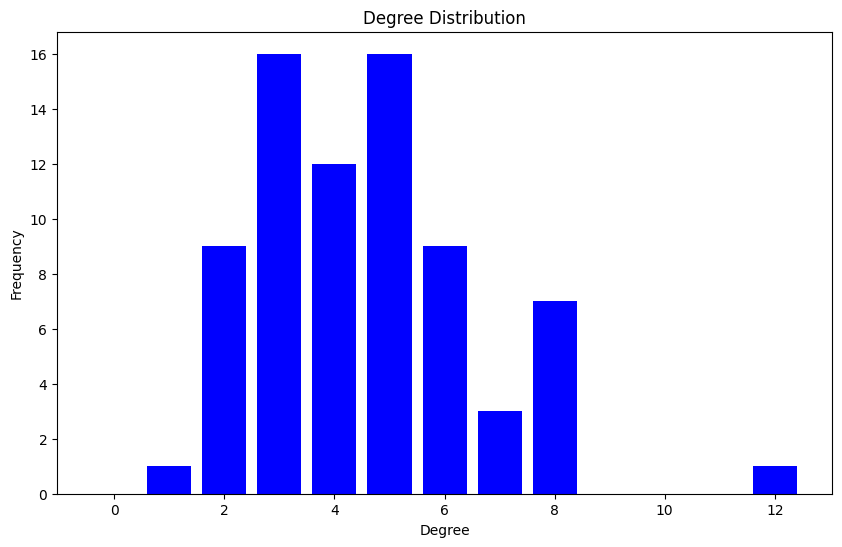

In [18]:
# compare calculated d and r values with actual values
analyze_graph(em_model)

In [19]:
nx.degree_assortativity_coefficient(em_model)

-0.043575977958141075

In [20]:
# get a degree distribution from Sioux Falls
sioux_degrees = [sioux_net.degree(n) for n in sioux_net.nodes()]
sioux_degree_counts = np.bincount(sioux_degrees)

In [21]:
# make that random model with that
sioux_graph = configuration_B(24, sioux_degree_counts)

In [22]:
sioux_graph_avg = nx.average_clustering(sioux_graph)

In [23]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0528
sioux_model, sioux_i, sioux_c_steps = model1(sioux_graph, sioux_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.01 seconds


In [24]:
sioux_model

In [25]:
sioux_i

95174

In [26]:
sioux_c_steps

[0.0625,
 0.2291666666666667,
 0.40416666666666673,
 0.09027777777777778,
 0.15277777777777776,
 0.3847222222222222,
 0.19166666666666665,
 0.32638888888888884,
 0.23888888888888893,
 0.42619047619047623,
 0.2347222222222222,
 0.2511904761904762,
 0.2763888888888889,
 0.30833333333333335,
 0.5307539682539681,
 0.3136363636363636,
 0.37754629629629627,
 0.23124999999999998,
 0.3905753968253968,
 0.30095899470899473,
 0.23650793650793653,
 0.3759920634920635,
 0.36398809523809517,
 0.47420634920634924,
 0.2791666666666667,
 0.3109457671957672,
 0.2533068783068783,
 0.29305555555555557,
 0.48035714285714276,
 0.3199404761904762,
 0.4255952380952381,
 0.5104166666666667,
 0.3759920634920635,
 0.40982142857142856,
 0.3753968253968254,
 0.3624999999999999,
 0.26825396825396824,
 0.37132936507936515,
 0.3763558201058202,
 0.3738095238095238,
 0.36081349206349206,
 0.3356481481481481,
 0.44156746031746025,
 0.3636453823953824,
 0.3406084656084656,
 0.2566137566137566,
 0.42996632996632994,
 0.

Diameter of the graph: 3
Average Clustering Coefficient: 0.7715791833438891


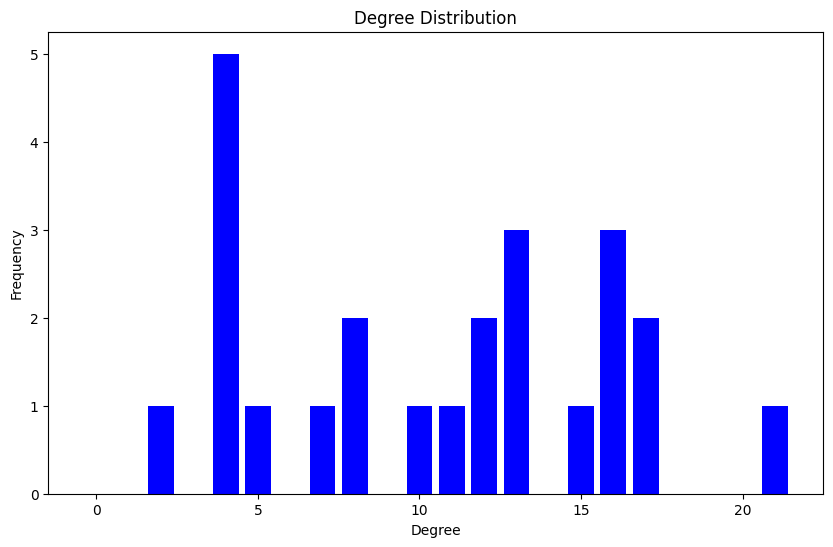

In [27]:
# compare calculated d and r values with actual values
analyze_graph(sioux_model)

In [28]:
nx.degree_assortativity_coefficient(sioux_model)

-0.37823855653331245

In [29]:
# get a degree distribution from Barcelona
bar_degrees = [bar_net.degree(n) for n in bar_net.nodes()]
bar_degree_counts = np.bincount(bar_degrees)

In [30]:
# make that random model with that
bar_graph = configuration_B(1020, bar_degree_counts)

In [31]:
bar_graph_avg = nx.average_clustering(bar_graph)

In [32]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0902
bar_model, bar_i, bar_c_steps = model1(bar_graph, bar_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.04 seconds


In [33]:
bar_model

In [34]:
bar_i

110

In [35]:
bar_c_steps

[0.001669000933706816,
 0.0068534787652434715,
 0.013648459383753498,
 0.01659515321280026,
 0.0047283761989644355,
 0.013338001867413633,
 0.010420168067226886,
 0.01782913165266106,
 0.013046218487394954,
 0.011308745720510422,
 0.019850606909430434,
 0.00850451291627762,
 0.014952536570183625,
 0.016659663865546216,
 0.016642545907251782,
 0.025175848117024592,
 0.013811858076563956,
 0.01283380018674136,
 0.011062869592281352,
 0.014441332088390898,
 0.020278555866791156,
 0.015432617491441012,
 0.024554933084344862,
 0.02147447868036103,
 0.017320261437908494,
 0.02309679427326486,
 0.022596412302294654,
 0.013917253770194935,
 0.016541182129417416,
 0.01952925614690322,
 0.016480703392468092,
 0.0134325750502221,
 0.02120278414396062,
 0.018221288515406164,
 0.022618269530034242,
 0.016223155929038266,
 0.022076719576719576,
 0.02704007865772573,
 0.020735860000565882,
 0.012823685029567362,
 0.019524277465453932,
 0.020963840081487144,
 0.01662146676852558,
 0.013960260872025568

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 9
Average Clustering Coefficient: 0.02259570494864613


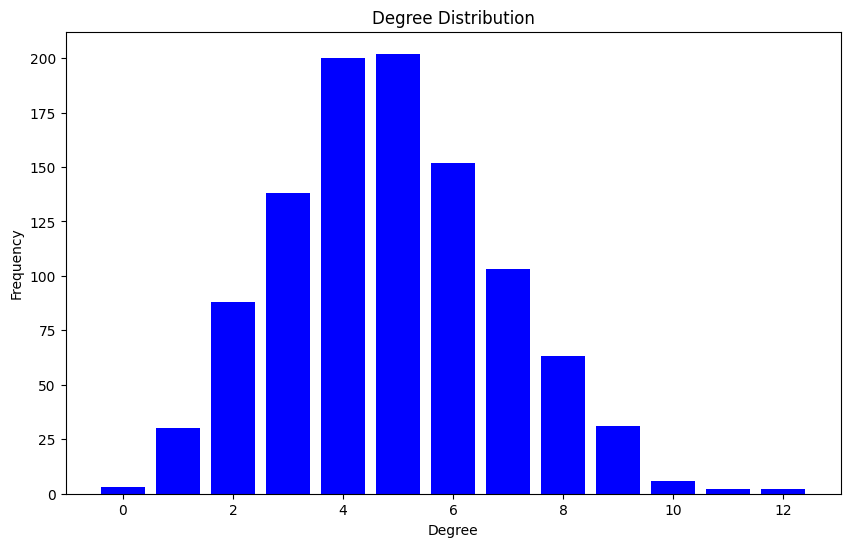

In [36]:
# compare calculated d and r values with actual values
analyze_graph(bar_model)

In [37]:
nx.degree_assortativity_coefficient(bar_model)

-0.051629513514175995

In [38]:
# get a degree distribution from Sydney
syd_degrees = [syd_net.degree(n) for n in syd_net.nodes()]
syd_degree_counts = np.bincount(syd_degrees)

In [39]:
# make that random model with that
syd_graph = configuration_B(33837, syd_degree_counts)

In [40]:
syd_graph_avg = nx.average_clustering(syd_graph)

In [41]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0074
syd_model, syd_i, syd_c_steps = model1(syd_graph, syd_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.08 seconds


In [42]:
syd_model

In [43]:
syd_i

1

In [44]:
syd_c_steps

[9.493458602422163e-05]

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 34
Average Clustering Coefficient: 0.00015810134836644277


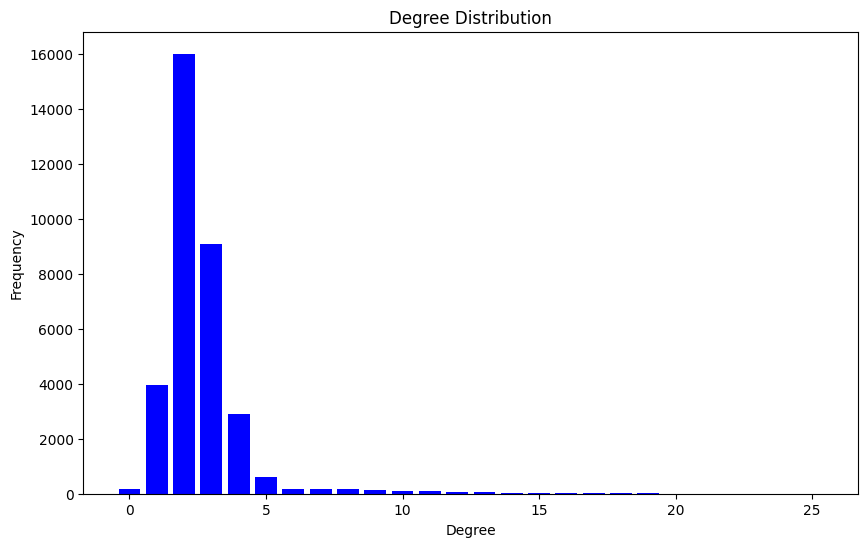

In [45]:
# compare calculated d and r values with actual values
analyze_graph(syd_model)

In [46]:
nx.degree_assortativity_coefficient(syd_model)

0.008715731538666399

In [47]:
# get a degree distribution from Winnipeg
win_degrees = [win_net.degree(n) for n in win_net.nodes()]
win_degree_counts = np.bincount(win_degrees)

In [48]:
# make that random model with that
win_graph = configuration_B(1052, win_degree_counts)

In [49]:
win_graph_avg = nx.average_clustering(win_graph)

In [50]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1045
win_model, win_i, win_c_steps = model1(win_graph, win_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3599.99 seconds


In [51]:
win_model

In [52]:
win_i

105

In [53]:
win_c_steps

[0.0022449484247886817,
 0.013294199463400986,
 0.003628010139416984,
 0.010198261814231398,
 0.014964693101575227,
 0.013389462248777836,
 0.01250452652543907,
 0.017083861427967896,
 0.014909620375399842,
 0.01019373528879232,
 0.011723700887198983,
 0.015625565815679882,
 0.00833333333333333,
 0.016003667857280024,
 0.016404882612106934,
 0.008751282515541069,
 0.018100066389039778,
 0.012723308588327592,
 0.016513519222644688,
 0.018992546321443655,
 0.016404059607481647,
 0.015842839036755384,
 0.01983070794857867,
 0.01654746816343774,
 0.012141718653125492,
 0.01874358742229464,
 0.020557969702456384,
 0.021730271207457522,
 0.021918053429460276,
 0.020778260607157945,
 0.01408503832458204,
 0.024249282614301624,
 0.01973482790973285,
 0.019537855469414417,
 0.023907598527370413,
 0.01966096324461343,
 0.02630507958454727,
 0.017748506246605098,
 0.019653582581339236,
 0.023690119555138566,
 0.01513683823569754,
 0.021295450430431413,
 0.014259926807455315,
 0.022487984132470842

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 9
Average Clustering Coefficient: 0.02422909789829944


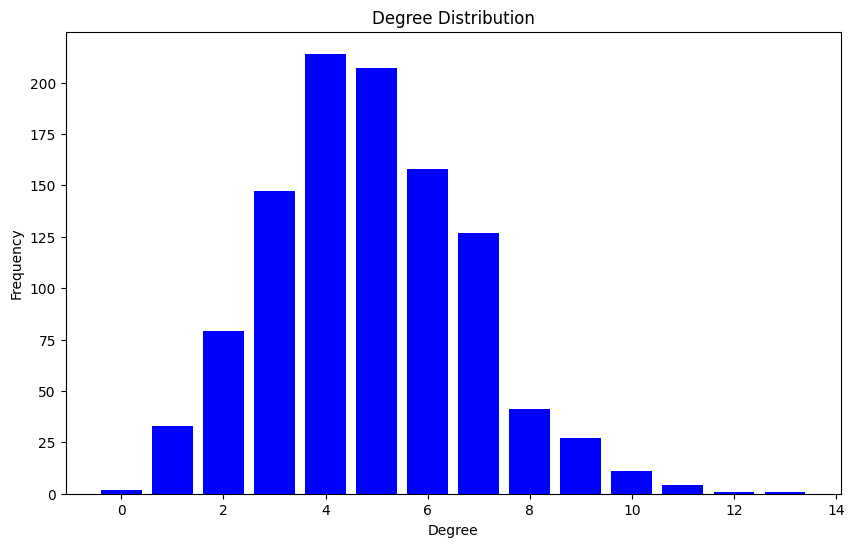

In [54]:
# compare calculated d and r values with actual values
analyze_graph(win_model)

In [55]:
nx.degree_assortativity_coefficient(win_model)

-0.010217752954065828

In [56]:
# get a degree distribution from Anaheim
ana_degrees = [ana_net.degree(n) for n in ana_net.nodes()]
ana_degree_counts = np.bincount(ana_degrees)

In [57]:
# make that random model with that
ana_graph = configuration_B(416, ana_degree_counts)

In [58]:
ana_graph_avg = nx.average_clustering(ana_graph)

In [59]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1076
ana_model, ana_i, ana_c_steps = model1(ana_graph, ana_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.06 seconds


In [60]:
ana_model

In [61]:
ana_i

587

In [62]:
ana_c_steps

[0.005161451796067181,
 0.02992406898656898,
 0.02495230463980464,
 0.023592032967032963,
 0.02412431318681318,
 0.04331501831501831,
 0.024627976190476183,
 0.02026671245421245,
 0.026991758241758233,
 0.023717948717948707,
 0.03915979853479853,
 0.03115270146520147,
 0.025185057997557988,
 0.028027701465201456,
 0.0411898865023865,
 0.03562999500499499,
 0.0544070512820513,
 0.0360214438339438,
 0.02615231990231989,
 0.03905677655677653,
 0.03760874542124541,
 0.041180173992674,
 0.04083295177045176,
 0.0433646214896215,
 0.03734165140415138,
 0.04046682484182482,
 0.039768391330891315,
 0.043925518925518915,
 0.02562003968253967,
 0.028163156288156282,
 0.04391597985347985,
 0.03366910866910865,
 0.04474015567765569,
 0.048172313797313786,
 0.03787965506715504,
 0.03983325702075701,
 0.04345428876678878,
 0.03368437118437116,
 0.03222870879120877,
 0.052686202686202714,
 0.056568431568431575,
 0.05552121489621489,
 0.04324252136752137,
 0.04260721916971918,
 0.04233821733821731,
 0.

Diameter of the graph: 7
Average Clustering Coefficient: 0.05111620484216634


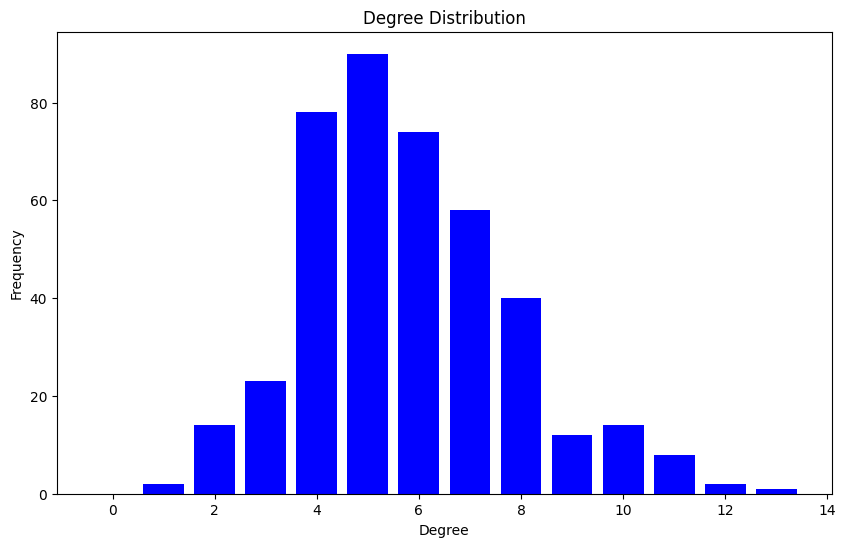

In [63]:
# compare calculated d and r values with actual values
analyze_graph(ana_model)

In [64]:
nx.degree_assortativity_coefficient(ana_model)

0.033194637078134095

In [65]:
# get a degree distribution from BerlinFriedrichshain
bf_degrees = [bf_net.degree(n) for n in bf_net.nodes()]
bf_degree_counts = np.bincount(bf_degrees)

In [66]:
# make that random model with that
bf_graph = configuration_B(224, bf_degree_counts)

In [67]:
bf_graph_avg = nx.average_clustering(bf_graph)

In [68]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1915
bf_model, bf_i, bf_c_steps = model1(bf_graph, bf_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.04 seconds


In [69]:
bf_model

In [70]:
bf_i

1888

In [71]:
bf_c_steps

[0.012585034013605443,
 0.04540516527123669,
 0.026459750566893418,
 0.058577806122448964,
 0.0588612528344671,
 0.024592545351473927,
 0.03696853741496598,
 0.0531675170068027,
 0.05948837868480721,
 0.04807256235827664,
 0.04685374149659861,
 0.04901502267573694,
 0.04576601473922901,
 0.05663265306122448,
 0.09109977324263037,
 0.06483843537414964,
 0.07009991496598637,
 0.06861536281179136,
 0.05412414965986393,
 0.06862244897959181,
 0.06862244897959184,
 0.047385204081632624,
 0.04852962018140587,
 0.08294359410430838,
 0.06569940476190475,
 0.043377976190476175,
 0.05958758503401358,
 0.04754464285714284,
 0.05899234693877548,
 0.08847080498866207,
 0.06484906462585034,
 0.06703869047619046,
 0.05099914965986392,
 0.04792020975056686,
 0.08999787414965986,
 0.06603599773242626,
 0.07543579931972784,
 0.06018282312925167,
 0.08026147959183672,
 0.06625212585034009,
 0.058312074829931955,
 0.0807079081632653,
 0.07476969954648524,
 0.07438704648526073,
 0.0809311224489795,
 0.0452

Diameter of the graph: 6
Average Clustering Coefficient: 0.11835774665343986


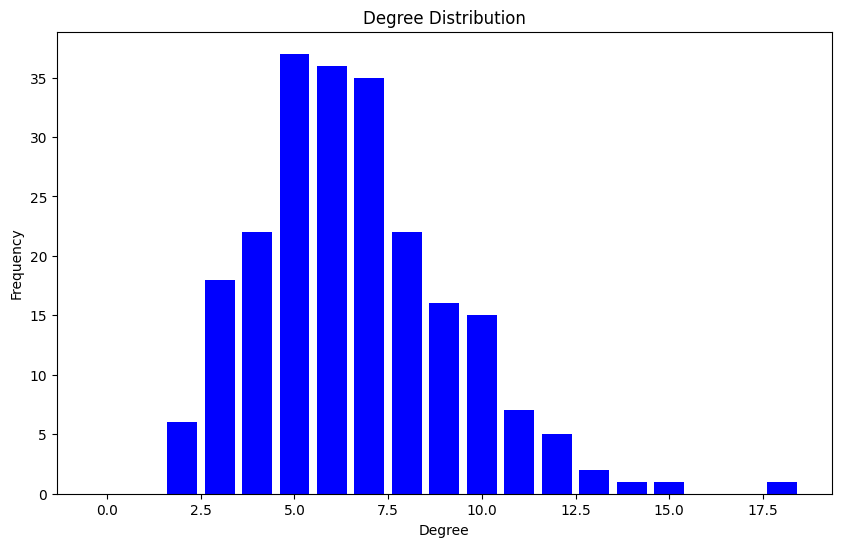

In [72]:
# compare calculated d and r values with actual values
analyze_graph(bf_model)

In [73]:
nx.degree_assortativity_coefficient(bf_model)

0.015739714689217196

In [74]:
# get a degree distribution from Berlin-Mitte-Center
bmc_degrees = [bmc_net.degree(n) for n in bmc_net.nodes()]
bmc_degree_counts = np.bincount(bmc_degrees)

In [75]:
# make that random model with that
bmc_graph = configuration_B(398, bmc_degree_counts)

In [76]:
bmc_graph_avg = nx.average_clustering(bmc_graph)

In [77]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.2048
bmc_model, bmc_i, bmc_c_steps = model1(bmc_graph, bmc_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.02 seconds


In [78]:
bmc_model

In [79]:
bmc_i

632

In [80]:
bmc_c_steps

[0.0,
 0.0152428810720268,
 0.014477147642976789,
 0.017408470926058867,
 0.021649916247906197,
 0.0317001675041876,
 0.03585187843981812,
 0.029636276621201232,
 0.036862885857860725,
 0.020202201483608517,
 0.023349068575199226,
 0.04493100422748664,
 0.03743718592964822,
 0.03267528116774347,
 0.05314070351758794,
 0.034392199090691536,
 0.046300949190396415,
 0.03552285235702319,
 0.032944484326393866,
 0.03751495573103611,
 0.03803541517109354,
 0.04776461673446596,
 0.04167264895908113,
 0.048831458881710144,
 0.050877402887453134,
 0.04390603812714363,
 0.041547020818377585,
 0.039690516072425616,
 0.03376550863988048,
 0.048124279405686435,
 0.03935750179468771,
 0.040374491505144744,
 0.04264178033022254,
 0.03051549232453754,
 0.04487716359575654,
 0.032144851240328606,
 0.054036053282284446,
 0.05102097790540002,
 0.06344819334769085,
 0.0641700566323682,
 0.047788545904123785,
 0.04932400095716675,
 0.04471364760309482,
 0.03994775464624708,
 0.04182021217197093,
 0.0592107

Diameter of the graph: 6
Average Clustering Coefficient: 0.06035847179063262


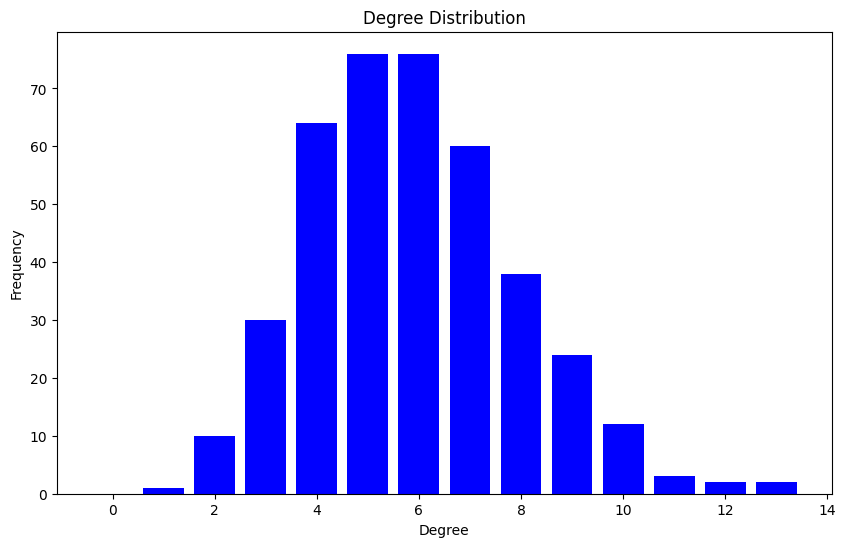

In [81]:
# compare calculated d and r values with actual values
analyze_graph(bmc_model)

In [82]:
nx.degree_assortativity_coefficient(bmc_model)

-0.029398083791802622